# CPSC - 393
## Homework 1: Support Vector Machines

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# models
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

1.	Load your data and do a 80/20 Train Test Split

In [50]:
data = pd.read_csv('hw1.csv')
print(data.shape)
data.head()

(1000, 9)


X1        X2        X3        X4        X5        X6        X7  \
0 -0.604285 -0.610629  0.026014  0.019710  0.406532  0.678796  0.524360   
1 -0.111772 -1.125178  0.744157  0.078315  0.088176  0.891009  0.018460   
2 -0.916802  1.965494  0.150022  0.388770  0.179276  0.064449  0.159279   
3 -0.280479  0.920669  0.208949  0.940153  0.854437  0.688172  0.365126   
4  1.856025  1.043214  0.167088  0.207002  0.979049  0.641019  0.628764   

         X8 Group  
0  0.404739     B  
1  0.536511     B  
2  0.951204     B  
3  0.985259     A  
4  0.045912     B

In [51]:
# check null vals
data.isna().sum()

X1       0
X2       0
X3       0
X4       0
X5       0
X6       0
X7       0
X8       0
Group    0
dtype: int64

In [52]:
# summary stats
data.groupby('Group').describe()

X1                                                              \
       count      mean       std       min       25%       50%       75%   
Group                                                                      
A      405.0 -0.610180  1.288966 -2.870362 -1.753766 -0.825742  0.578027   
B      595.0  0.843523  1.276210 -2.151491 -0.280349  1.059486  1.931226   

                    X2            ...        X7               X8            \
            max  count      mean  ...       75%       max  count      mean   
Group                             ...                                        
A      1.906522  405.0  1.280941  ...  0.759876  0.985987  405.0  0.474073   
B      3.289581  595.0  0.029502  ...  0.689367  0.985987  595.0  0.480692   

                                                                   
            std       min       25%       50%       75%       max  
Group                                                              
A      0.300570  0.005381  0.198308  0.479805  0.731367  0.999016  
B      0.305629  0.002317  0.176609  0.482490  0.733842  0.999016  

[2 rows x 64 columns]

<Figure size 200x100 with 0 Axes>

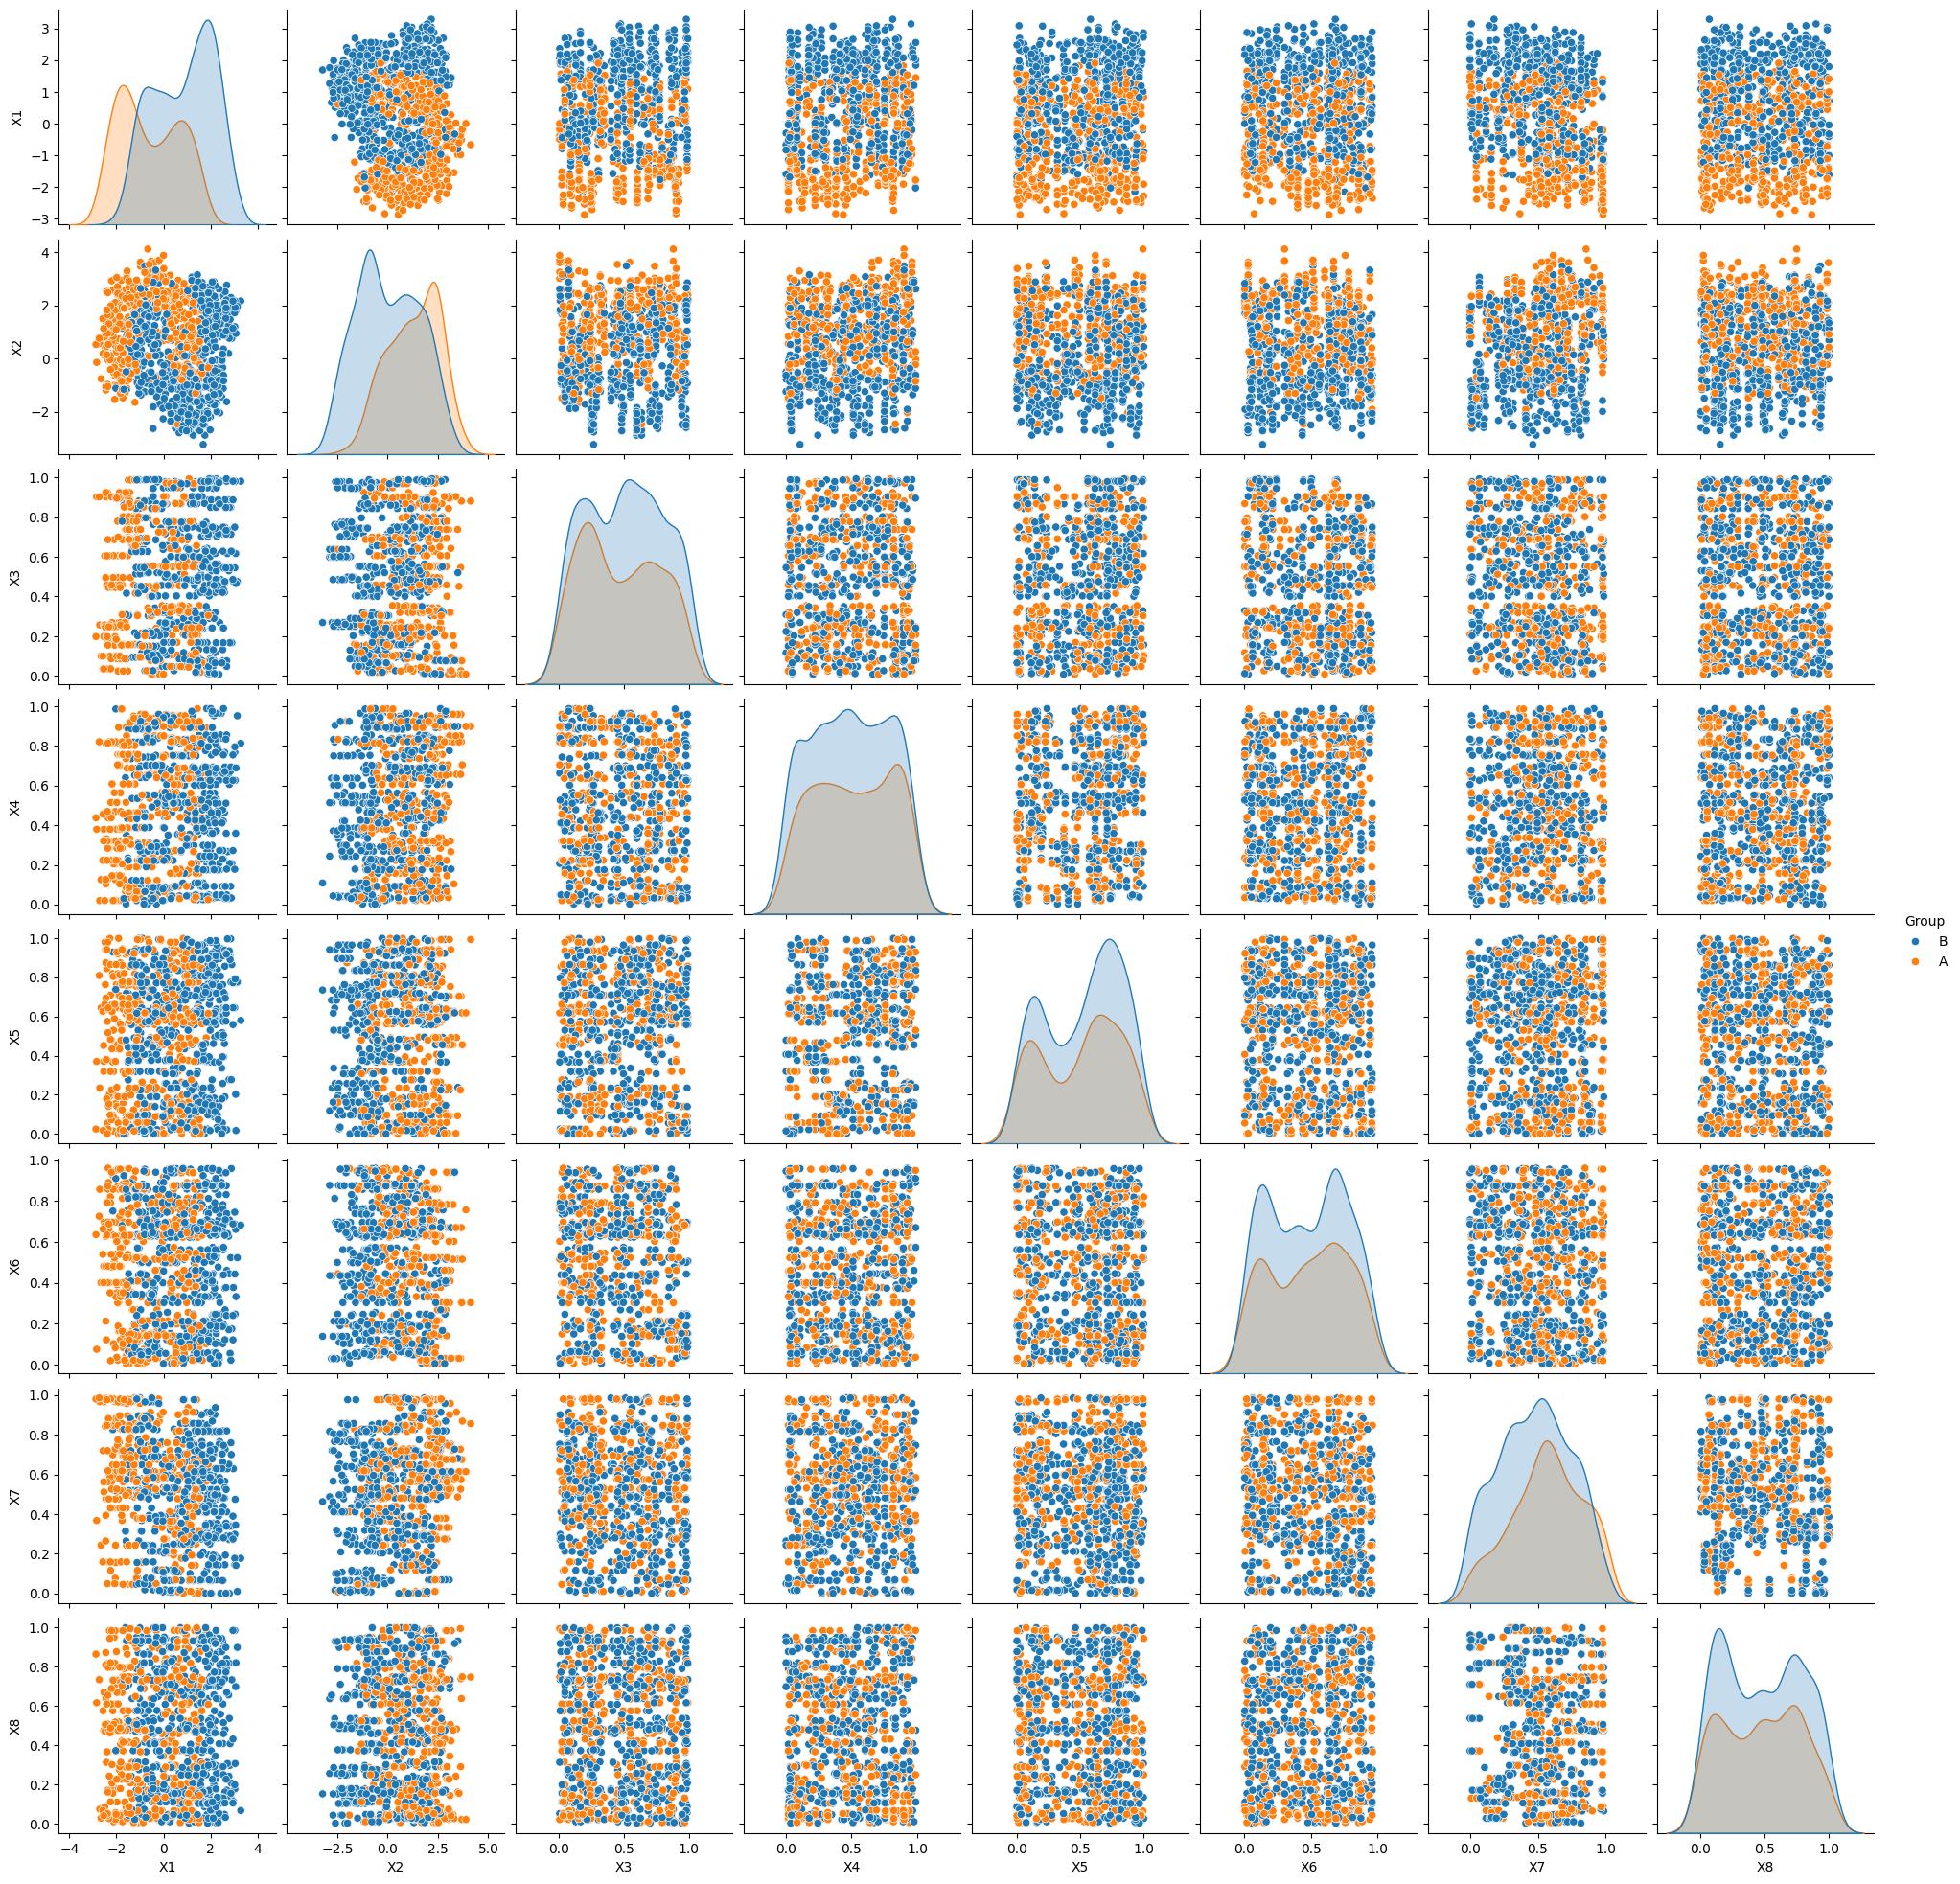

In [53]:
# nonlinearity and distribution check
fig = plt.figure(figsize=(2, 1))
sns.pairplot(data, hue='Group')
plt.show()

In [54]:
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'X8']]
y = data['Group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### SVM
2.	Use sklearn Pipelines to build an SVM model. Use GridSearchCV to choose the kernel (choose from `linear` and `rbf`), C (choose from `[0.001, 0.01, 1, 5, 25, 50]`), and gamma (choose from `[0.001,0.01, 0.1, 0.5, 1,2,5]`). Print out the train and test accuracies and ROC/AUCs, and plot the train and test confusion matrices. 

In [55]:
column_transformer = make_column_transformer(
    (StandardScaler(), X.columns), # z scoring
    remainder='passthrough'
)

svc = SVC(probability=True)
pipeline = make_pipeline(column_transformer, svc)

display(pipeline)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'X8'], dtype='object'))])),
                ('svc', SVC(probability=True))])

In [56]:
param_grid = {
    'svc__C': [0.001, 0.01, 1, 0.5, 1, 5, 25, 50],
    'svc__gamma': [0.001,0.01, 0.1, 0.5, 1,2,5],
    'svc__kernel': ['linear', 'rbf']
}

grid_pipeline = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)

# fit and predict with best model
grid_pipeline.fit(X_train, y_train)

# best model
print(f'Best parameters for SVC: {grid_pipeline.best_params_}')
best_model = grid_pipeline.best_estimator_

Best parameters for SVC: {'svc__C': 1, 'svc__gamma': 0.5, 'svc__kernel': 'rbf'}


In [57]:
# Accuracy for SVM
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'''
SVM MODEL:

Train Accuracy: {train_accuracy}
Test Accuracy: {test_accuracy}''')

# ROC AUC for SVM
y_train_prob = best_model.predict_proba(X_train)[:, 1]
y_test_prob = best_model.predict_proba(X_test)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_prob)
test_roc_auc = roc_auc_score(y_test, y_test_prob)

print(f'''
Train ROC AUC: {train_roc_auc}
Test ROC AUC: {test_roc_auc}''')


SVM MODEL:

Train Accuracy: 0.895
Test Accuracy: 0.775

Train ROC AUC: 0.9729770373470028
Test ROC AUC: 0.8319667982589329


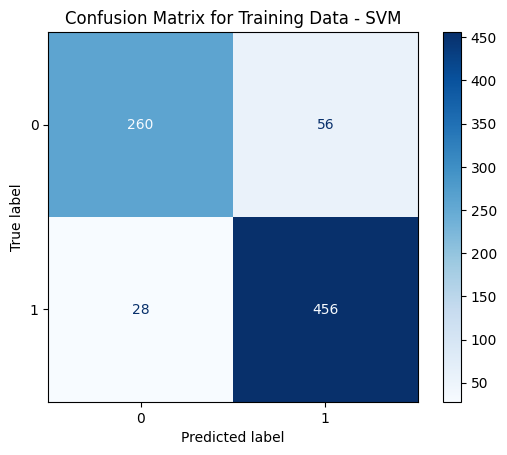

In [58]:
# TRAIN CM
cm = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for Training Data - SVM")
plt.show()

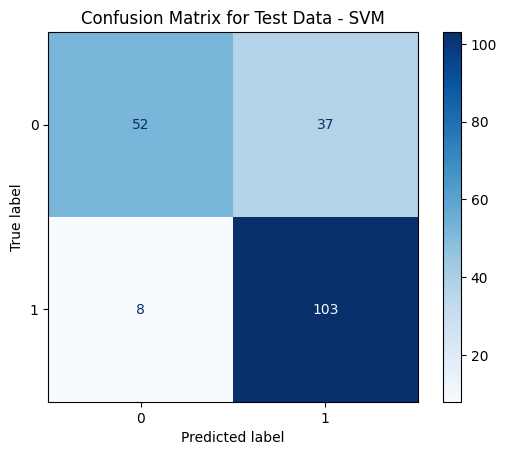

In [59]:
# TEST CM
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for Test Data - SVM")
plt.show()

### Logistic Regression
3.	Use sklearn Pipelines to build a Logistic Regression on the same data with the same train/test set. Print out the train and test accuracies and ROC/AUCs, and plot the train and test confusion matrices. 

In [60]:
lr = LogisticRegression()
pipeline = make_pipeline(column_transformer, lr)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'X8'], dtype='object'))])),
                ('logisticregression', LogisticRegression())])

In [61]:
# Accuracy for log reg
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'''
Logistic Regression:

Train Accuracy: {train_accuracy}
Test Accuracy: {test_accuracy}''')

# ROC AUC for log reg
y_train_prob = pipeline.predict_proba(X_train)[:, 1]
y_test_prob = pipeline.predict_proba(X_test)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_prob)
test_roc_auc = roc_auc_score(y_test, y_test_prob)

print(f'''
Train ROC AUC: {train_roc_auc}
Test ROC AUC: {test_roc_auc}''')


Logistic Regression:

Train Accuracy: 0.7575
Test Accuracy: 0.765

Train ROC AUC: 0.8390325870906998
Test ROC AUC: 0.862840368458346


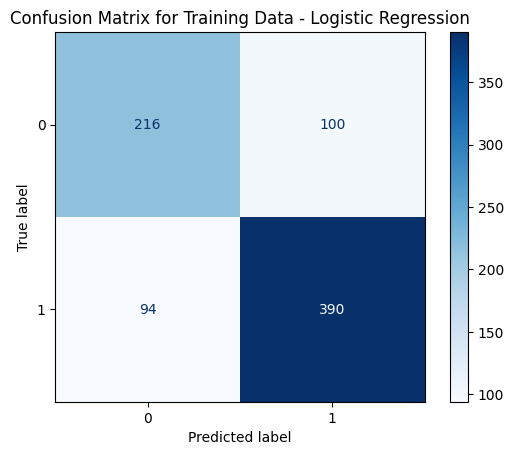

In [62]:
# TRAIN for log reg
cm = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for Training Data - Logistic Regression")
plt.show()

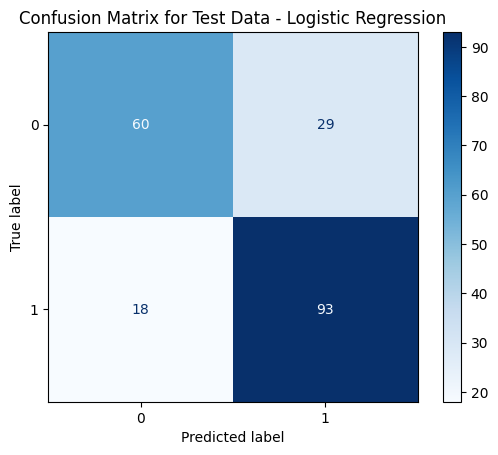

In [63]:
# TEST for log reg
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for Test Data - Logistic Regression")
plt.show()

### K Nearest Neighbors
4.	Use sklearn Pipelines to build a KNearest Neighbors model on the same data with the same train/test set (use GridSearch to choose `n_neighbors`).Print out the train and test accuracies and ROC/AUCs, and plot the train and test confusion matrices.   

In [64]:
knn = KNeighborsClassifier()
pipeline = make_pipeline(column_transformer, knn)

param_grid = {
    'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9, 11, 15]
}

grid_pipeline = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)

grid_pipeline.fit(X_train, y_train)

# best model
print(f'Best parameters for SVC: {grid_pipeline.best_params_}')
best_model = grid_pipeline.best_estimator_

Best parameters for SVC: {'kneighborsclassifier__n_neighbors': 11}


In [65]:
# Accuracy for KNN
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'''
KNN: 

Train Accuracy: {train_accuracy}
Test Accuracy: {test_accuracy}''')

# ROC AUC for KNN
y_train_prob = best_model.predict_proba(X_train)[:, 1]
y_test_prob = best_model.predict_proba(X_test)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_prob)
test_roc_auc = roc_auc_score(y_test, y_test_prob)

print(f'''
Train ROC AUC: {train_roc_auc}
Test ROC AUC: {test_roc_auc}''')


KNN: 

Train Accuracy: 0.7875
Test Accuracy: 0.76

Train ROC AUC: 0.8783705146981903
Test ROC AUC: 0.8354590545601782


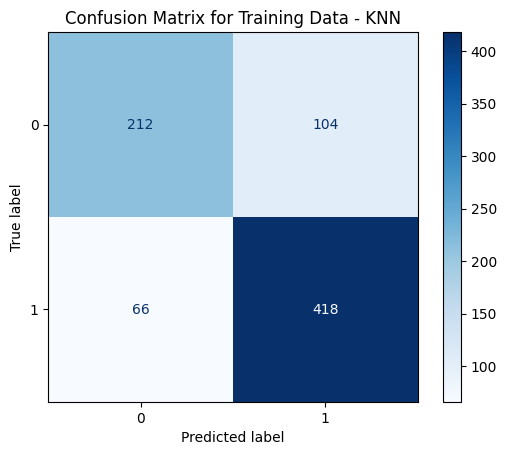

In [66]:
# TRAIN
cm = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for Training Data - KNN")
plt.show()

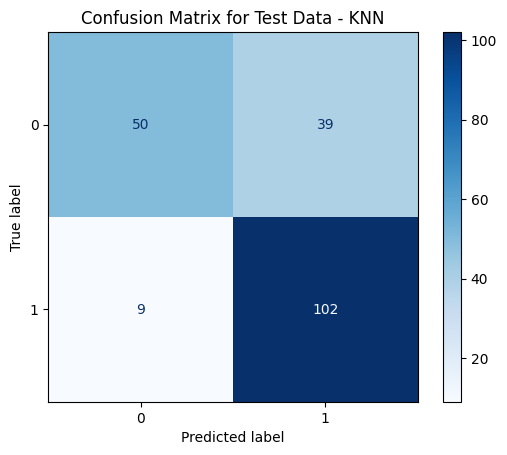

In [67]:
# TEST 
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for Test Data - KNN")
plt.show()